# Optimize GradientBoostingClassifier
Using the previously determined variable list, lets see what we get in terms of optimization for the training settings.

# Initalization

In [1]:
from bdt_training_scikit_tools import load_trimmed_sample, default_training_variable_list, \
    test_train_samples, prep_samples, default_training, calc_performance
import matplotlib.pyplot as plt
plt.rc('font', size=14)
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
import multiprocessing as mp
import itertools
from sklearn.ensemble import GradientBoostingClassifier

## Load data

In [2]:
%%time
input_events = load_trimmed_sample(106)

Job 106:
  BIB: 800000 events
  Multijet: 800000 events
  Signal: 800000 events
  [800000, 800000, 504190]
CPU times: user 9.51 s, sys: 1.65 s, total: 11.2 s
Wall time: 11.2 s


In [3]:
def fraction (fractionGoal):
    '''Return a function that will take from a randomly distributed number a fraction of events.
    Meant to be used against an EventNumber to evenly pair down the number of events.
    
    Args
        fractionGoal - the fraction of events we'd like to see
        
    Returns
        func - A function that will return True or False when given an event number. True, then keep the event.
    '''
    if (fractionGoal < 0) | (fractionGoal > 1.0):
        raise Exception("Fraction must be between 0.0 and 1.0 (not {0})".format(fractionGoal))
        
    seq = ()
    fg = fractionGoal
    maxCount = 300
    for i in range(1, maxCount):
        frac = 1.0/i
        if frac <= fg:
            seq = seq + (i,)
            remainingSequence = [i for i in range(maxCount) if len([j for j in seq if i%j == 0]) != 0]
            actualFraction = len(remainingSequence)/maxCount
            fg = fractionGoal - actualFraction

    return seq
    #return lambda x: len([i for i in seq if x%i == 0]) != 0
    #return lambda x: x%i == 0
    
def calcDFFilter (df, seq):
    gf, *gfRest = [df.EventNumber%i==0 for i in seq]
    for g in gfRest:
        gf = gf | g
    return gf

def get_fraction_of_events(events, fractionToUse):
    '''Return a fraction of all events as training and testing samples.
    
    Args
        fractionToUse - fraction of the full datasample we should be using
        
    Returns
        training - Training tripple of events (bib, mj, sig)
        testing - Testing tripple of events (bib, mj, sig)
    
    '''
    # Create the per event filter. We have to do this against each
    # of the three input samples.
    seq = fraction(fractionToUse)
    fracFilters = [calcDFFilter(df, seq) for df in events]

    fraction_events = [dfi[1][dfi[0]] for dfi in zip(fracFilters,events)]
    return fraction_events

In [4]:
events_50 = get_fraction_of_events(input_events, 0.5)
events_25 = get_fraction_of_events(input_events, 0.25)

In [5]:
print ([len(i.index) for i in events_50])
print ([len(i.index) for i in events_25])

[401512, 400246, 251612]
[201018, 200123, 126005]


## Training
We want to be able run multiple trainings in threads, so we have to be a little tricky here by writing out a file.

In [6]:
%%writefile grad_perf_training.py
from bdt_training_scikit_tools import default_training_variable_list, \
    test_train_samples, prep_samples, calc_performance
from sklearn.ensemble import GradientBoostingClassifier
    
def do_training (vlist):
    all_events, test_events, leaf_depth, estimators = vlist
    return get_training_performance (all_events, test_events, leaf_depth, estimators)
    
def get_training_performance (all_events, test_events, leaf_depth, estimators):
    '''Run a training with the set of varaibles given. Return a performance table.'''
    
    # Split into testing and training samples
    train, test = test_train_samples(all_events)
    
    # Prep samples for training
    all_events, all_events_class, training_weight, evaluation_weight = prep_samples(train[0], train[1], train[2])
    
    # If a test sample was used, then use that instead.
    if test_events != None:
        test = test_events
        
    # Run training
    bdt = GradientBoostingClassifier(max_depth=leaf_depth, n_estimators=estimators)
    bdt.fit(all_events, all_events_class.Class, sample_weight = training_weight)
    
    # Create a thing of all the results
    return {(leaf_depth, estimators): calc_performance(bdt, test)}

Overwriting grad_perf_training.py


Make sure this works well. The first implementation was generating some warnings while running - this will run on a small number of events and make sure it runs without errors

In [7]:
%%time
train, test = test_train_samples(events_25)
all_events, all_events_class, training_weight, evaluation_weight = prep_samples(train[0], train[1], train[2])
bdt = GradientBoostingClassifier(max_depth=3, n_estimators=3)
bdt.fit(all_events, all_events_class.Class, sample_weight=training_weight)

CPU times: user 4.56 s, sys: 106 ms, total: 4.67 s
Wall time: 4.66 s


In [8]:
import grad_perf_training
pool = mp.Pool(processes=10)

In [9]:
def scan_performance(all_events, leaf_depth_range=[3], estimators=[10], test_events = None):
    results = pool.map(grad_perf_training.do_training,
             [(all_events, test_events, ldepth, nest) for ldepth in leaf_depth_range for nest in estimators])

    one_dict = {}
    for kp in results:
        one_dict.update(kp)

    return pd.DataFrame(one_dict).T

## Leaf Depth and Estimators
These two have to be connected, right?

First a short timing test to see how this works - this should be very quick (or order 2 minutes).

In [10]:
%%time
lde = scan_performance(input_events)

CPU times: user 314 ms, sys: 435 ms, total: 748 ms
Wall time: 1min 47s


In [11]:
lde[['HSSSsqrtB','HSSEff','BIBEff','MJEff']]

,,HSSSsqrtB,HSSEff,BIBEff,MJEff
3,10,24.221105,0.964939,0.381099,0.849596


Ok, now look a bit at what happens with more trees, but the same number of estimators.

This is currently commented out because it takes a crazy amount of time to run

In [12]:
%%time
#treeDepth = scan_performance(input_events, leaf_depth_range=[10, 12, 15], estimators=[10])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [13]:
#treeDepth[['HSSSsqrtB','HSSEff','BIBEff','MJEff']]

## Number of events
The number of events at 800,000 can take a crazy amount of time to run.

In [14]:
%%time
lde = scan_performance(events_50)
lde[['HSSSsqrtB','HSSEff','BIBEff','MJEff']]

CPU times: user 126 ms, sys: 239 ms, total: 365 ms
Wall time: 42 s


In [15]:
lde[['HSSSsqrtB','HSSEff','BIBEff','MJEff']]

,,HSSSsqrtB,HSSEff,BIBEff,MJEff
3,10,16.74784,0.966165,0.378604,0.844676


In [16]:
%%time
lde = scan_performance(events_25)
lde[['HSSSsqrtB','HSSEff','BIBEff','MJEff']]

CPU times: user 62.5 ms, sys: 115 ms, total: 177 ms
Wall time: 15 s


In [17]:
lde[['HSSSsqrtB','HSSEff','BIBEff','MJEff']]

,,HSSSsqrtB,HSSEff,BIBEff,MJEff
3,10,12.107716,0.964335,0.379924,0.848643


In [18]:
%%time
#treeSmallEvents = scan_performance(events_25, leaf_depth_range=[10], estimators=[10])
#treeDepth[['HSSSsqrtB','HSSEff','BIBEff','MJEff']]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


In [19]:
%%time
lde = scan_performance(events_25, test_events = input_events)

CPU times: user 307 ms, sys: 506 ms, total: 812 ms
Wall time: 19.1 s


In [20]:
lde[['HSSSsqrtB','HSSEff','BIBEff','MJEff']]

,,HSSSsqrtB,HSSEff,BIBEff,MJEff
3,10,40.929413,0.962974,0.380852,0.849645


In [21]:
%%time
lde = scan_performance(events_50, test_events = input_events)

CPU times: user 383 ms, sys: 619 ms, total: 1 s
Wall time: 45.6 s


In [22]:
lde[['HSSSsqrtB','HSSEff','BIBEff','MJEff']]

,,HSSSsqrtB,HSSEff,BIBEff,MJEff
3,10,40.46175,0.965027,0.380593,0.848839


SO, looking at this, it looks like the size of the event sample is not affecting things - so we can try training with the 25% list to see what happens from it. That is good news, since, above, the 50% is 46 seconds, and the 25% is 18.6s, and 100% is 109s. Wait. lets plot that. :-)

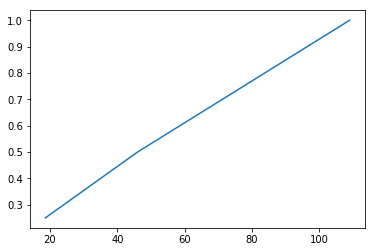

In [23]:
timing = [18.6, 46.0, 109.0]
fraction = [0.25, 0.50, 1.0]
fig = plt.figure()
plt.plot(timing, fraction)
plt.show()

## Number of estimators
The literature seems to say you want very shallow trees. Depth of 3, means 4 leaves, for example. And then you want to do sub-sampling. So lets see how the performance improves with more trees, but the same number of levels (3).

In [24]:
%%time
ntrees = scan_performance(events_25, leaf_depth_range=[3], estimators=[10, 50, 100, 200, 300, 400, 600, 800,1000], test_events = input_events)

CPU times: user 6.74 s, sys: 8.8 s, total: 15.5 s
Wall time: 52min 22s


In [29]:
ntrees[['HSSSsqrtB','HSSEff', 'HSSinHSS', 'BIBinHSS','MJinHSS']]

HSSSsqrtB    HSSEff  HSSinHSS  BIBinHSS       MJinHSS
3 10    40.929413  0.962974  485522.0   58637.0  1.406584e+08
  50    49.595556  0.983415  495828.0   47522.0  9.990104e+07
  100   55.631732  0.983820  496032.0   36775.0  7.946452e+07
  200   63.431873  0.984294  496271.0   28305.0  6.118174e+07
  300   68.722212  0.984607  496429.0   25003.0  5.215691e+07
  400   73.531772  0.984964  496609.0   23166.0  4.558883e+07
  600   80.185872  0.985139  496697.0   21038.0  3.834857e+07
  800   86.881288  0.985353  496805.0   19717.0  3.267815e+07
  1000  90.810437  0.985581  496920.0   18875.0  2.992455e+07

In [30]:
ntrees

BIBBack    BIBEff  BIBSsqrtB  BIBTotalCount  BIBTotalWeight  \
3 10    2.339620e+08  0.380852  19.919303       800000.0        800000.0   
  50    4.607869e+08  0.507934  18.929843       800000.0        800000.0   
  100   5.635909e+08  0.553306  18.645480       800000.0        800000.0   
  200   6.382447e+08  0.591866  18.742174       800000.0        800000.0   
  300   6.516685e+08  0.605357  18.970927       800000.0        800000.0   
  400   6.637855e+08  0.614511  19.081211       800000.0        800000.0   
  600   6.695869e+08  0.629149  19.450907       800000.0        800000.0   
  800   6.683152e+08  0.640306  19.814680       800000.0        800000.0   
  1000  6.778696e+08  0.649070  19.943825       800000.0        800000.0   

        BIBinBIB  BIBinHSS   BIBinMJ       HSSBack    HSSEff      ...       \
3 10    304682.0   58637.0  436681.0  1.407171e+08  0.962974      ...        
  50    406347.0   47522.0  346131.0  9.994857e+07  0.983415      ...        
  100   442645.0   36775.0  320580.0  7.950130e+07  0.983820      ...        
  200   473493.0   28305.0  298202.0  6.121005e+07  0.984294      ...        
  300   484286.0   25003.0  290711.0  5.218192e+07  0.984607      ...        
  400   491609.0   23166.0  285225.0  4.561200e+07  0.984964      ...        
  600   503319.0   21038.0  275643.0  3.836961e+07  0.985139      ...        
  800   512245.0   19717.0  268038.0  3.269787e+07  0.985353      ...        
  1000  519256.0   18875.0  261869.0  2.994342e+07  0.985581      ...        

        HSSinHSS  HSSinMJ    MJBack     MJEff      MJSsqrtB  MJTotalCount  \
3 10    485522.0   6278.0  442959.0  0.849645  3.180653e+06      800000.0   
  50    495828.0   4603.0  350734.0  0.774961  3.260252e+06      800000.0   
  100   496032.0   4467.0  325047.0  0.741901  3.242153e+06      800000.0   
  200   496271.0   4119.0  302321.0  0.719276  3.259281e+06      800000.0   
  300   496429.0   3873.0  294584.0  0.717511  3.293700e+06      800000.0   
  400   496609.0   3723.0  288948.0  0.715283  3.315344e+06      800000.0   
  600   496697.0   3619.0  279262.0  0.715861  3.375072e+06      800000.0   
  800   496805.0   3560.0  271598.0  0.718647  3.435681e+06      800000.0   
  1000  496920.0   3432.0  265301.0  0.715918  3.463012e+06      800000.0   

        MJTotalWeight       MJinBIB       MJinHSS        MJinMJ  
3 10     2.491497e+09  2.339496e+08  1.406584e+08  2.116889e+09  
  50     2.491497e+09  4.607831e+08  9.990104e+07  1.930813e+09  
  100    2.491497e+09  5.635872e+08  7.946452e+07  1.848445e+09  
  200    2.491497e+09  6.382409e+08  6.118174e+07  1.792074e+09  
  300    2.491497e+09  6.516646e+08  5.215691e+07  1.787675e+09  
  400    2.491497e+09  6.637817e+08  4.558883e+07  1.782126e+09  
  600    2.491497e+09  6.695830e+08  3.834857e+07  1.783565e+09  
  800    2.491497e+09  6.683114e+08  3.267815e+07  1.790507e+09  
  1000   2.491497e+09  6.778657e+08  2.992455e+07  1.783707e+09  

[9 rows x 24 columns]

In [ ]:
%%time
ntrees = scan_performance(events_25, leaf_depth_range=[3], estimators=[200, 300], test_events = input_events)

In [ ]:
ntrees[['HSSSsqrtB','HSSEff','BIBEff','MJEff']]

In [ ]:
%%time
ntrees = scan_performance(events_25, leaf_depth_range=[3], estimators=[400, 600], test_events = input_events)

In [ ]:
ntrees[['HSSSsqrtB','HSSEff','BIBEff','MJEff']]

In [ ]:
%%time
ntrees = scan_performance(events_25, leaf_depth_range=[3], estimators=[800, 1000], test_events = input_events)

In [ ]:
ntrees[['HSSSsqrtB','HSSEff','BIBEff','MJEff']]

In [ ]:
%%time
ntrees = scan_performance(events_25, leaf_depth_range=[3], estimators=[800, 1000], test_events = input_events)

In [ ]:
ntrees[['HSSSsqrtB','HSSEff','BIBEff','MJEff']]